In [1]:
from google.colab import files
uploaded = files.upload()

Saving squares_7.tiff to squares_7.tiff


In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import pandas as pd
from PIL import Image
from numpy import asarray
from scipy.sparse import coo_matrix
from sklearn.feature_extraction import image
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings("ignore")

In [10]:
def compute_adj_deg_matrices(image_array):
  # Initialize the graph with the 4-neighbor graph
  graph = image.img_to_graph(image_array.astype(float))

  # As Intensities can have values between 0-255, 
  #we use the sigma value with 15% of 255
  sigma = 255*0.15
  graph.data = np.exp(-np.square(graph.data / sigma)/2) # This is called the Kernel Matrix

  # Now, let us compute the adjacency Matrix
  adjacency = graph.toarray()-np.diag(np.diag(graph.toarray()))

  # With that info, let us calculate the Degree matrix
  degree = np.matrix(np.diag(np.sqrt(np.power(adjacency.sum(axis=1),-1))))

  # Compute the edges of the adjacency matrix
  edges = []
  for i in range(adjacency.shape[0]):
    for j in range(i, adjacency.shape[1]):
      if adjacency[i,j]!=0 and i!=j:
        edges.append((i,j))
  return adjacency, degree, edges


# Now, let us compute the Normalized Laplacian
def compute_Laplacian_matrix(adjacency, degree):
  adjacency_normalized_cuts = np.matmul(degree,np.matmul(adjacency,degree))
  L = np.matrix(np.eye(adjacency.shape[0]))-adjacency_normalized_cuts
  Laplacian = coo_matrix(L)
  return Laplacian


# Compute the smallest eigenvalues and eigenvectors of the Laplacian matrix
def compute_spectrum(Laplacian):
  # Use the 6 smallest eigenvalues and eigenvectors
  eigenvalues, eigenvectors = sla.eigs(Laplacian, 6, which='SM') 
  return eigenvalues, eigenvectors


def sort_matrix_spectrum(eigenvalues, eigenvectors):
  # sort the eigenvalues
  index_list = np.argsort(eigenvalues)

  # create eigenvector Matrix V
  V_matrix = np.zeros((eigenvectors.shape[0],2))
  V_matrix[:,0] = eigenvectors[:,index_list[0]]
  V_matrix[:,1] = eigenvectors[:,index_list[1]]

  # normalize the first 2 rows of the eigenvector matrix
  V_matrix_normed  = normalize(np.real(V_matrix), axis=1)
  return V_matrix_normed


def compute_segmentation(eigenvectors):
  # Let us initialize the V matrix with the same number of rows and columns
  V = np.zeros(eigenvectors.shape).astype(int)  # .shape throws the rows and columns
  for i in range(eigenvectors.shape[0]): # number of rows
    for j in range(eigenvectors.shape[1]): # number of columns
      if eigenvectors[i,j] > 0:  # above 0 belongs to one cluster
        V[i,j] = 1
      else:
        V[i,j] = 0
  return V

In [11]:
def get_list_of_images():
    list_images = uploaded.keys()
    return list_images


def open_image(file_name):
  imag = Image.open(file_name) 
  image_array = np.asarray(imag)
  return image_array


def number_of_qubits(flatten_img):
    qubits = np.log2(flatten_img.shape[0])+1
    return qubits.astype(int)


def plot_segmentation_results(image_array, V_matrix):
  fig, axs = plt.subplots(1,1, figsize = (3.5,3.5), constrained_layout=True, sharey=True)
  # show the clusters 
  axs.matshow(V_matrix[:,1].reshape(image_array.shape), cmap=plt.get_cmap('gray'))
  axs.set_title('Normalized Cuts', ha="center", va="center", color="k", fontsize=20, fontweight = 'medium')
  axs.set_xticks(np.arange(-0.5,4.5))
  axs.set_yticks(np.arange(-0.5,4.5))
  axs.set_xticklabels([])
  axs.set_yticklabels([])
  plt.show()


# Create the network or Graph using Nx library to compute the cut size
def create_network(adjacency_matrix, edges):
    # Identify working pixels
    number_of_pixels = adjacency_matrix.shape[0]

    # Populate a networkx graph with pixels as nodes.
    working_graph = nx.Graph()
    for node in range(number_of_pixels):
        working_graph.add_node(node)

    # Pair up all neighbors with random weights in working_graph.
    for pixel in edges:
        working_graph.add_edge(pixel[0], pixel[1], weight=adjacency_matrix[pixel[0], pixel[1]])
    return working_graph, number_of_pixels


# Compute the size of the cut given the segmentation list and the graph
def compute_cut_size(segmentation_list, graph):
    df = pd.Series(segmentation_list)
    one_qubits = set(df[df==1].index)
    S_partition = set()
    T_partition = set()

    for node in graph:
        if node in one_qubits:
            # If a one was measured add node to S partition.
            S_partition.add(node)
        else:
            # Otherwise a zero was measured so add to T partition.
            T_partition.add(node)

    cut_size = nx.normalized_cut_size(graph, S_partition, T_partition, weight='weight')
    return cut_size

def compute_average_std_of_cuts(total_cuts):
    cut_tot = np.array(total_cuts)
    average = np.around(cut_tot.mean(),6)
    std_dev = np.around(cut_tot.std(),6)
    return average, std_dev

In [12]:
def main():
  list_of_images = ['squares_7.tiff']#get_list_of_images()
  results = []

  for image in list_of_images:
    # Open the image 
    image_array = open_image(image)
    
    minimum_cut = np.inf # best cut must be less than a big number
    partial_results = []
    for iterations in range(10):
      # Compute the adjacency matrix and the degree matrix
      adjacency_matrix, degree_matrix, edges = compute_adj_deg_matrices(image_array)

      # Compute the normalized Laplacian matrix
      normalized_laplacian = compute_Laplacian_matrix(adjacency_matrix, degree_matrix)

      # Compute the smallest eigenvectors and eigenvalues
      eigenvalues, eigenvectors = compute_spectrum(normalized_laplacian)
      normalized_eigenvectors = sort_matrix_spectrum(eigenvalues, eigenvectors)# the index will help to plot 

      # Compute the matrix of eigenvectors corresponding to the 2 smalles eigenvalues 
      segmentation_matrix = compute_segmentation(normalized_eigenvectors) 

      # Plot the results
      if iterations == 1:
        plot_segmentation_results(image_array, segmentation_matrix)

      # Compute the cut size of the segmentation made
      nx_graph, pixels = create_network(adjacency_matrix, edges)
      
      # compute and append results
      cut_size = compute_cut_size(segmentation_matrix[:,1], nx_graph)

      # Choose the minimum cut 
      if cut_size < minimum_cut:
        minimum_cut = np.around(cut_size,6)
      partial_results.append(cut_size)
    display(segmentation_matrix[:,1])
    average, std_dev = compute_average_std_of_cuts(partial_results)
    results.append([minimum_cut, average, std_dev])

  return results

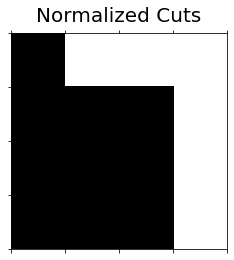

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1])

In [13]:
import pandas as pd

results = main()
results_df = pd.DataFrame(results)
results_df.to_excel("Results_Spectral_Clustering.xlsx") 

In [ ]:
results_df

,0,1,2
0,0.062293,0.062293,0.0
1,0.368400,0.368400,0.0
2,0.002245,0.002245,0.0
3,0.064722,0.064722,0.0
4,0.038018,0.038018,0.0
5,0.003898,0.003898,0.0
6,0.636561,0.636561,0.0
7,0.001190,0.001190,0.0
8,0.001651,0.001651,0.0
9,0.000001,0.000001,0.0
